## Metrics for binary classification problems

In this notebook, we'll explore various metrics used to evaluate the performance of binary classification models. We will use the Wisconsin Breast Cancer dataset, and logistic regression as our model. However, the metrics here are applicable to any binary classification model, not just logistic regression.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

### Loading the Data

Let's load the Wisconsin Breast Cancer dataset from the GitHub repository. 

The dataset contains 569 samples with 30 features each, computed from images of breast mass cell nuclei. Our target variable (`diagnosis`) indicates whether the tumor is:
- **B** (Benign): Not cancerous
- **M** (Malignant): Cancerous

We'll create a binary label where 0 = Benign and 1 = Malignant for our model.

In [2]:
cancer_data = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")
# Create binary label: 0 for Benign (B), 1 for Malignant (M)
cancer_data["label"] = cancer_data["diagnosis"].apply(lambda x: 0 if x == "B" else 1)
cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,...,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme,label
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### Building a Simple Logistic Regression Model

We'll build a simple logistic regression model using only **one feature**: `radius_mean` (the mean radius of the cell nuclei). 

We will use the `scikit-learn` library to build the model. This is a popular library for machine learning in Python.

Specifically, we'll use the `LogisticRegression` class from the `linear_model` module. 
You can find the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**Note**: We're using `penalty=None` to avoid regularization, keeping the model as simple as possible for demonstration purposes.


In [3]:
# fit the logistic regression model
lr_model = LogisticRegression(penalty=None, random_state=42)
lr_model.fit(
    X=cancer_data[["radius_mean"]],
    y=cancer_data["label"],
)

lr_model

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Metrics based on classified results

Now that we have our model, let's make predictions and evaluate its performance using various metrics.

Note that, by default, the `predict` method returns the predicted class labels, that is, 0 or 1.
Although the logistic regression model outputs probabilities, the `predict` method uses a default 
threshold of 0.5 to convert the probabilities to class labels.

**Key Concepts:**
- **True Positive (TP)**: Total number of correctly predicted as positive (i.e., malignant, 1)
- **True Negative (TN)**: Total number of correctly predicted as negative (i.e., benign, 0)
- **False Positive (FP)**: Total number of negative cases incorrectly predicted as positive (Type I error)
- **False Negative (FN)**: Total number of positive cases incorrectly predicted as negative (Type II error)

From these, we can calculate:
- **Accuracy** = (TP + TN) / Total → Overall correctness
- **Precision** = TP / (TP + FP) → When we predict positive, how often are we right?
- **Recall (Sensitivity)** = TP / (TP + FN) → Of all actual positive cases, how many did we catch?
- **F1-Score** = Harmonic mean of Precision and Recall → Balance between precision and recall


In [4]:
from typing import Any

def evaluate_classification(
    threshold: float,
    model: Any,
    X: np.ndarray | pd.DataFrame | pd.Series,
    y_truth: np.ndarray | pd.Series):
    """Evaluates a classification model with a custom threshold.

    Args:
        threshold (float): Classification threshold (0 to 1). Values >= threshold
            are classified as positive (1).
        model: Trained logistic regression or similar model with predict_proba method.
        X (array-like): Feature matrix for predictions.
        y_truth (array-like): True labels.

    Returns:
        dict: Dictionary containing all metrics including accuracy, precision,
            recall, f1_score, confusion matrix, and individual TP/TN/FP/FN values.
    """
    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X)[:, 1]

    # Apply custom threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate confusion matrix
    cm = confusion_matrix(y_truth, y_pred)

    # Display confusion matrix
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: Benign (0)", "Actual: Malignant (1)"],
        columns=["Predicted: Benign (0)", "Predicted: Malignant (1)"]
    )

    print("="*70)
    print(f"CONFUSION MATRIX (Threshold = {threshold:.2f})")
    print("="*70)
    print(cm_df)
    print("\n" + "-"*70)

    # Calculate metrics
    accuracy = accuracy_score(y_truth, y_pred)
    precision = precision_score(y_truth, y_pred, zero_division=0)
    recall = recall_score(y_truth, y_pred, zero_division=0)
    f1 = f1_score(y_truth, y_pred, zero_division=0)

    print("CLASSIFICATION METRICS")
    print("="*70)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f}")
    print("="*70)

    # Return metrics as dictionary
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'true_negatives': cm[0,0],
        'false_positives': cm[0,1],
        'false_negatives': cm[1,0],
        'true_positives': cm[1,1]
    }


In [5]:
# Evaluate with default threshold of 0.5
threshold = 0.5
print("\n" + f"🔍 Evaluating with Default Threshold ({threshold})" + "\n")
_ = evaluate_classification(
    threshold=threshold,
    model=lr_model,
    X=cancer_data[["radius_mean"]],
    y_truth=cancer_data["label"]
)


🔍 Evaluating with Default Threshold (0.5)

CONFUSION MATRIX (Threshold = 0.50)
                       Predicted: Benign (0)  Predicted: Malignant (1)
Actual: Benign (0)                       333                        24
Actual: Malignant (1)                     45                       167

----------------------------------------------------------------------
CLASSIFICATION METRICS
Accuracy:  0.8787 (87.87%)
Precision: 0.8743 (87.43%)
Recall:    0.7877 (78.77%)
F1-Score:  0.8288


In [6]:
# Evaluate with default threshold of 0.8
threshold = 0.8
print("\n" + f"🔍 Evaluating with Default Threshold ({threshold})" + "\n")
_ = evaluate_classification(
    threshold=threshold,
    model=lr_model,
    X=cancer_data[["radius_mean"]],
    y_truth=cancer_data["label"]
)


🔍 Evaluating with Default Threshold (0.8)

CONFUSION MATRIX (Threshold = 0.80)
                       Predicted: Benign (0)  Predicted: Malignant (1)
Actual: Benign (0)                       351                         6
Actual: Malignant (1)                     80                       132

----------------------------------------------------------------------
CLASSIFICATION METRICS
Accuracy:  0.8489 (84.89%)
Precision: 0.9565 (95.65%)
Recall:    0.6226 (62.26%)
F1-Score:  0.7543


#### Interpreting the Results

From the confusion matrix and metrics above, we can see:

1. **Accuracy** tells us the overall correctness, but can be misleading if classes are imbalanced
2. **Precision** is important when false positives are costly (e.g., unnecessary treatments)
3. **Recall** is critical when false negatives are dangerous (e.g., missing a cancer diagnosis)
4. **F1-Score** helps when you need to balance precision and recall

### Metrics based on probabilities

#### ROC Curve and AUC: Evaluating Performance Across All Thresholds

**ROC** stands for "Receiver Operating Characteristic." Instead of using a fixed threshold (like 0.5), the ROC curve shows how our model performs across **all possible thresholds**.

#### Key Concepts:
- **False Positive Rate (FPR)**: What fraction of benign tumors are incorrectly classified as malignant?
  - FPR = FP / (FP + TN) = FP / (All Actual Negatives)
  - Also called (1 - Specificity)

- **True Positive Rate (TPR)**: What fraction of malignant tumors are correctly identified?
  - TPR = TP / (TP + FN) = TP / (All Actual Positives)
  - Also called Sensitivity or Recall

The ROC curve plots **TPR vs FPR** as we vary the classification threshold from 0 to 1.

#### Understanding the ROC Curve:
- **Perfect classifier**: Would have TPR = 1 and FPR = 0 (top-left corner)
- **Random classifier**: Would follow the diagonal line (TPR = FPR)
- **Good classifier**: Curve bows toward the top-left, showing high TPR with low FPR

#### Area Under the Curve (AUC):
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: No better than random guessing

Let's visualize this for our model:

In [7]:
# make prediction on the training dataset
prediction_results = pd.DataFrame(
    data={
        "probability": lr_model.predict_proba(cancer_data[["radius_mean"]])[:, 1],
        "label": cancer_data["label"],
    }
)

# take a look some random samples
prediction_results.sample(10, random_state=123).sort_values("probability")

,probability,label
273,0.005604,0
333,0.026101,0
469,0.037806,0
297,0.043439,1
216,0.049381,0
178,0.141919,0
500,0.574352,0
209,0.631220,0
201,0.947085,1
85,0.978876,1


In [8]:
# Calculate the values needed for the ROC curve
fpr, tpr, thresholds = roc_curve(
    y_true=prediction_results["label"],
    y_score=prediction_results["probability"],
)

# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(
    y_true=prediction_results["label"],
    y_score=prediction_results["probability"]
)

print(f"AUC Score: {auc:.4f}")

# Store the data in a DataFrame for inspection
roc_data = pd.DataFrame(
    data={
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds,
    },
)

print("\nSample of ROC data points (last 5 rows):")
roc_data.tail()

AUC Score: 0.9375

Sample of ROC data points (last 5 rows):


,fpr,tpr,thresholds
183,0.871148,1.0,0.006619
184,0.876751,1.0,0.006432
185,0.887955,1.0,0.005679
186,0.893557,1.0,0.005604
187,1.000000,1.0,0.000324


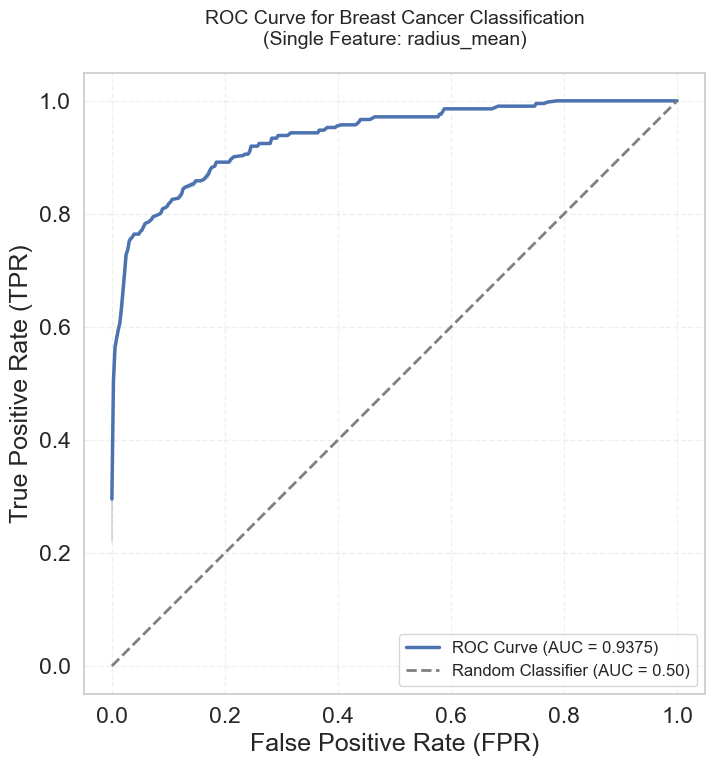

In [9]:
# Create the ROC curve plot
plt.figure(figsize=(8, 8))

# Plot the ROC curve
sns.lineplot(x=fpr, y=tpr, linewidth=2.5, label=f"ROC Curve (AUC = {auc:.4f})")

# Plot the diagonal line (random classifier baseline)
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", color="gray", linewidth=2, label="Random Classifier (AUC = 0.50)")

# Formatting
plt.gca().set_aspect("equal")
plt.gca().set_xlabel("False Positive Rate (FPR)")
plt.gca().set_ylabel("True Positive Rate (TPR)")
plt.gca().set_title("ROC Curve for Breast Cancer Classification\n(Single Feature: radius_mean)", fontsize=14, pad=20)
plt.gca().set_xlim([-0.05, 1.05])
plt.gca().set_ylim([-0.05, 1.05])
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()